In [1]:
import sys, os
import numpy as np
import pandas as pd
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pdb
from joblib import Parallel, delayed
import multiprocessing
from scipy.stats import entropy
from datetime import datetime, timedelta
import epiweeks as epi
from scipy.stats import pearsonr
from scipy.signal import correlate
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.fftpack import fft, ifft
from scipy.optimize import nnls
import scipy.stats as stats
from scipy.optimize import leastsq
from scipy.signal import savgol_filter
from collections import defaultdict
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [2]:
def conv_patch(pdf,val):
    tpdfm=pdf.pivot(columns='fct_date',index='cnty',values=val)
    tpdfm.columns=pd.to_datetime(tpdfm.columns,infer_datetime_format=True)
    cols=tpdfm.columns
    incols=pd.date_range(start=cols.min(),end=cols.max()+timedelta(days=6),freq='1D')
    pdfm=pd.DataFrame(columns=incols,index=tpdfm.index)
    pdfm.loc[:,tpdfm.columns]=tpdfm.loc[:,tpdfm.columns]/7
    pdfm=pdfm.fillna(method='ffill',axis=1)#.interpolate(method='cubic')
    ddf=df.set_index('FIPS')
    ddf.columns=pd.to_datetime(ddf.columns,infer_datetime_format=True)
    ddf=ddf.diff(axis=1).fillna(0)
    ddf=ddf.loc[:,ddf.columns.min():pdfm.columns.min()-timedelta(days=1)]
    ddf=ddf.merge(pdfm,left_index=True,right_index=True)
#     ddf=ddf.rolling(7,axis=1).mean().fillna(0)
    return ddf


def conv_patch_2weeks(pdf,val):
    tpdfm=pdf[pdf.step_ahead.isin(['1-step_ahead','2-step_ahead'])].pivot(columns='fct_date',index='cnty',values=val)
    tpdfm.columns=pd.to_datetime(tpdfm.columns,infer_datetime_format=True)
    cols=tpdfm.columns
    incols=pd.date_range(start=cols.min(),end=cols.max()+timedelta(days=6),freq='1D')
    pdfm=pd.DataFrame(columns=incols,index=tpdfm.index)
    pdfm.loc[:,tpdfm.columns]=tpdfm.loc[:,tpdfm.columns]/7
    pdfm=pdfm.fillna(method='ffill',axis=1)#.interpolate(method='cubic')
    ddf=df.set_index('FIPS')
    ddf.columns=pd.to_datetime(ddf.columns,infer_datetime_format=True)
    ddf=ddf.diff(axis=1).fillna(0)
    ddf=ddf.loc[:,ddf.columns.min():pdfm.columns.min()-timedelta(days=1)]
    ddf=ddf.merge(pdfm,left_index=True,right_index=True)
    ddf=ddf.rolling(7,axis=1).mean().fillna(0)
    return ddf

In [3]:
def get_week(date, weeks):
    for week in weeks:
        s,e = week.split('_')
        if s <= date and date <= e:
            return week

fipsdf=pd.read_csv('../misc_data/US_fips_codes_names.csv')
fipsdf['FIPS']=fipsdf.FIPS.apply(lambda x: '{:05}'.format(x))
mapfips=dict(zip(fipsdf['FIPS'],fipsdf['County']+'_'+fipsdf['name']))
mapname=dict(zip(fipsdf['County']+'_'+fipsdf['name'],fipsdf['FIPS']))

goog_dates=[]
with open('input/goog_dates.txt','r') as f:
    for line in f:
        goog_dates.append(line[:-1])
goog_dates
stdt=goog_dates[-1].split('_')[0]
for i in range(1,40):
    dt0=(datetime.strptime(stdt,'%Y-%m-%d')+timedelta(weeks=i)).strftime('%Y-%m-%d')
    dt1=(datetime.strptime(dt0,'%Y-%m-%d')+timedelta(days=6)).strftime('%Y-%m-%d')
    goog_dates.append(dt0+'_'+dt1)

sorted(goog_dates)[-1]

'2023-06-18_2023-06-24'

In [4]:
file="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
df = pd.read_csv(file,header=0,dtype={'UID':str,'code3':str,'FIPS':str})
df=df.dropna(subset=['FIPS'])
df.loc[:,'FIPS']=df.FIPS.apply(lambda x : '{:05}'.format(int(float(x))))
all_dict={}
for st in df.Province_State:
        all_dict[st]=dict(zip(df[df.Province_State==st]['FIPS'],df[df.Province_State==st]['Admin2']))
df.drop(columns=['Country_Region','Lat','Long_','iso2','iso3','UID','code3','Admin2','Combined_Key','Province_State'],inplace=True)
agg_df=df.dropna(subset=['FIPS'])
agg_df.loc[:,'FIPS']=agg_df.FIPS.astype(float)
agg_df.FIPS=agg_df.FIPS.apply(lambda x: '{:05}'.format(int(x)))
# agg_df = df.groupby(['Province_State']).agg(np.sum)
dates = agg_df.iloc[:,1:].columns.tolist()
dates = [datetime.strptime(x, '%m/%d/%y') for x in dates]
dates = [x.strftime('%Y-%m-%d') for x in dates]
agg_df.iloc[:,1:].columns = dates
for x in agg_df.iloc[:,1:].columns:
    agg_df=agg_df.rename(columns={x:datetime.strptime(x, '%m/%d/%y').strftime('%Y-%m-%d')})
# agg_df.loc[:,'admin_st']=agg_df.Admin2+'_'+agg_df.Province_State
# agg_df=agg_df.drop(columns=['Admin2','Province_State'])
agg_df=agg_df.set_index('FIPS')
# dates = agg_df.columns
agg_df.groupby((np.arange(len(agg_df.columns)) // 7) + 1, axis=1).sum().add_prefix('s')
agg_df.columns = [get_week(x,goog_dates) for x in dates]
agg_df = agg_df.groupby(agg_df.columns,axis=1).max()
dates = agg_df.columns.values.tolist()
new_df = agg_df.copy()
for i in range(len(dates)):
    d, prev_d = dates[i], dates[i-1]
    new_df[d] = agg_df[d] - agg_df[prev_d]
    
covid_df = new_df.copy()
covid_dates = dates

# agg_df.index=agg_df.index.map(mapname)
# agg_df=agg_df[agg_df.index.notna()]
# new_df.index=new_df.index.map(mapname)
# new_df=new_df[new_df.index.notna()]

for col in agg_df.columns:
    agg_df=agg_df.rename(columns={col:col.split('_')[0]})
for col in new_df.columns:
    new_df=new_df.rename(columns={col:col.split('_')[0]})
    

for col in new_df.columns:
    new_df=new_df.rename(columns={col:datetime.strptime(col,'%Y-%m-%d').date()})

diff_df=new_df.diff(axis=1).fillna(0)
data_df=np.log(new_df.mask(new_df<=0)).fillna(0)#diff_df

new_df[new_df<=0]=1

for col in new_df.columns:
    if col=='FIPS':
        continue
    else:
        new_df=new_df.rename(columns={col:col.strftime('%Y-%m-%d')})
newdf=new_df.reset_index()
cols=new_df.columns
mnewdf=pd.melt(newdf,id_vars=['FIPS'], value_vars=cols,
        var_name='fct_date', value_name='true')
mnewdf=mnewdf.rename(columns={'FIPS':'cnty'})

In [5]:
popdf=pd.read_csv('../misc_data1/countypops_2016.txt',sep=" ", header=None, names=['cnty','pop'], dtype={'cnty':str})

In [6]:
ptdf=pd.read_csv('/project/biocomplexity/aniadiga/covid-19_forecast/output/PatchSim/PatchSim_adpt_20210125.csv',dtype={'fips':str})
cn_list=ptdf.fips.unique()

In [7]:
fl_list=['02158',
 '02195',
 '02198',
 '02230',
 '02275',
 '08014',
 '12086',
 '15005']

In [8]:
set.intersection(set(cn_list),set(fl_list))

{'02158', '02195', '02198', '02230', '02275', '08014', '12086', '15005'}

In [9]:
ddf=df.set_index('FIPS')
ddf.columns=pd.to_datetime(ddf.columns,infer_datetime_format=True)
ddf=ddf.diff(axis=1).fillna(0)
col0=ddf.columns[0]

ddf=ddf.drop(col0,axis=1)
ll=[]
st0=ddf.columns[0]
for i in ddf.columns:
    ddf=ddf.rename(columns={i:(i-st0).days})

cols_gt=ddf.columns
rndf=ddf.sum().rolling(7).mean().fillna(0)


In [19]:
dts=pd.to_datetime(df.set_index('FIPS').columns,infer_datetime_format=True)
dt0=dts[1]
dtdict={}
for dt in dts[1:]:
    dtdict.update({dt.strftime('%Y-%m-%d'):(dt-dt0).days})

In [10]:
pdt='2021-04-11'
pdf=pd.read_csv('output/bma_all_methods_PatchSim_adpt-B117_{}.csv'.format(pdt),dtype={'cnty':str})
pdf.loc[:,'fct_lb']=pdf.loc[:,'fct_mean']-1.96*pdf.loc[:,'fct_std']
pdf.loc[:,'fct_ub']=pdf.loc[:,'fct_mean']+1.96*pdf.loc[:,'fct_std']

In [11]:
pdf[pdf.horizon==pdt].method.unique()

array(['AR_spatial', 'AR', 'ARIMA', 'PatchSim_adpt', 'PatchSim_adpt-B117',
       'lstm', 'BMA-ensemble'], dtype=object)

In [12]:
fipsdf1=pd.read_csv('input/fips_map.csv',dtype={'FIPS':str,'St_code':str})

In [13]:
fipsdf1=fipsdf1.drop('cnty',axis=1).rename(columns={'cnty':'FIPS'})

In [14]:
# fipsdf1

In [15]:
fipsdict=fipsdf1[['FIPS','location_code']]

In [17]:
for mtd in pdf.method.unique():
    print(mtd,pdf[(pdf.method==mtd)].horizon.unique().max())

AR_spatial 2021-04-11
AR 2021-04-11
ARIMA 2021-04-11
PatchSim_adpt 2021-04-11
PatchSim_adpt-B117 2021-04-11
lstm 2021-04-11
BMA-ensemble 2021-04-11


ENKF


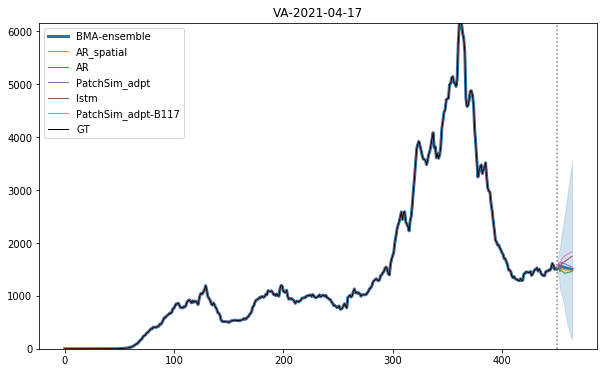

In [20]:
for hdt in [pdt]:#[pdf.horizon.unique().max()]:#['2020-10-25', '2020-10-18', '2020-10-11', '2020-10-04']:
    obsdt=(datetime.strptime(hdt,'%Y-%m-%d')+timedelta(days=6)).strftime('%Y-%m-%d')
    st='VA'
    fig,ax=plt.subplots(1,1,figsize=(10,6))
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    clr=0
    st_cn_list=fipsdict[fipsdict.location_code==st]['FIPS'].values
    rndf=ddf[ddf.index.isin(st_cn_list)].sum().rolling(7).mean().fillna(0)
    for mtd in ['BMA-ensemble', 'AR_spatial', 'AR','ENKF', 'PatchSim_adpt','lstm','PatchSim_adpt-B117']:#'AR_spatial_mob','ARIMA','lstm',
        try:
            mask=(pdf.method==mtd)&(pdf.horizon==hdt)
            ddf_med=conv_patch_2weeks(pdf[mask],'fct_mean')
            ddf_lb=conv_patch_2weeks(pdf[mask],'fct_lb')
            ddf_ub=conv_patch_2weeks(pdf[mask],'fct_ub')
            col0=ddf_med.columns[0]
            ddf_med=ddf_med.drop(col0,axis=1)
            ddf_lb=ddf_lb.drop(col0,axis=1)
            ddf_ub=ddf_ub.drop(col0,axis=1)

            ll=[]
            st0=ddf_med.columns[0]
            for i in ddf_med.columns:
                ddf_med=ddf_med.rename(columns={i:(i-st0).days})

            ll=[]
            st0=ddf_lb.columns[0]
            for i in ddf_lb.columns:
                ddf_lb=ddf_lb.rename(columns={i:(i-st0).days})
            ddf_lb[ddf_lb<=0]=0
            ll=[]
            st0=ddf_ub.columns[0]
            for i in ddf_ub.columns:
                ddf_ub=ddf_ub.rename(columns={i:(i-st0).days})
            ddf_ub[ddf_ub<=0]=0

            if mtd=='BMA-ensemble':
                alp=1
                lw=3
            else:
                alp=0.4
                lw=1

            cols=list(ddf_med.columns)
            ax.plot(ddf_med[ddf_med.index.isin(st_cn_list)].sum().values,color=cycle[clr],label=mtd, linewidth=lw)
            if mtd=='BMA-ensemble':
                ax.fill_between(cols,ddf_lb[ddf_lb.index.isin(st_cn_list)].sum().values,ddf_ub[ddf_ub.index.isin(st_cn_list)].sum().values,alpha=0.2,color=cycle[clr])
                ymax=ddf_ub[ddf_ub.index.isin(st_cn_list)].sum().max()
            ax.set_title('{}-{}'.format(st,obsdt))
            clr+=1
        except:
            print(mtd)
            clr+=1
            continue
    ax.plot(rndf.values,label='GT',color='black',linewidth=1)
    ax.axvline(x=dtdict[obsdt],color='grey',linestyle=':')
    ax.set_ylim(0,ymax)
    ax.legend()
    plt.savefig('plots/cdc_forecast_ensemble/2_week_wtd_BMA_with_B117_{}_{}.pdf'.format(st,obsdt),bbox_inches='tight')


    #     fig.autofmt_xdate()

ENKF


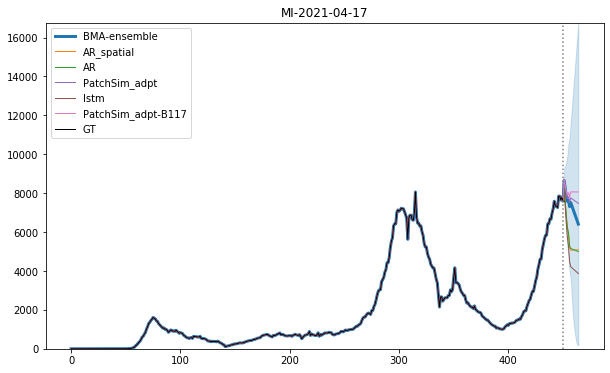

In [21]:
for hdt in [pdt]:#[pdf.horizon.unique().max()]:#['2020-10-25', '2020-10-18', '2020-10-11', '2020-10-04']:
    obsdt=(datetime.strptime(hdt,'%Y-%m-%d')+timedelta(days=6)).strftime('%Y-%m-%d')
    st='MI'
    fig,ax=plt.subplots(1,1,figsize=(10,6))
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    clr=0
    st_cn_list=fipsdict[fipsdict.location_code==st]['FIPS'].values
    rndf=ddf[ddf.index.isin(st_cn_list)].sum().rolling(7).mean().fillna(0)
    for mtd in ['BMA-ensemble', 'AR_spatial', 'AR','ENKF', 'PatchSim_adpt','lstm','PatchSim_adpt-B117']:#'AR_spatial_mob','ARIMA','lstm',
        try:
            mask=(pdf.method==mtd)&(pdf.horizon==hdt)
            ddf_med=conv_patch_2weeks(pdf[mask],'fct_mean')
            ddf_lb=conv_patch_2weeks(pdf[mask],'fct_lb')
            ddf_ub=conv_patch_2weeks(pdf[mask],'fct_ub')
            col0=ddf_med.columns[0]
            ddf_med=ddf_med.drop(col0,axis=1)
            ddf_lb=ddf_lb.drop(col0,axis=1)
            ddf_ub=ddf_ub.drop(col0,axis=1)

            ll=[]
            st0=ddf_med.columns[0]
            for i in ddf_med.columns:
                ddf_med=ddf_med.rename(columns={i:(i-st0).days})

            ll=[]
            st0=ddf_lb.columns[0]
            for i in ddf_lb.columns:
                ddf_lb=ddf_lb.rename(columns={i:(i-st0).days})
            ddf_lb[ddf_lb<=0]=0
            ll=[]
            st0=ddf_ub.columns[0]
            for i in ddf_ub.columns:
                ddf_ub=ddf_ub.rename(columns={i:(i-st0).days})
            ddf_ub[ddf_ub<=0]=0

            if mtd=='BMA-ensemble':
                alp=1
                lw=3
            else:
                alp=0.4
                lw=1

            cols=list(ddf_med.columns)
            ax.plot(ddf_med[ddf_med.index.isin(st_cn_list)].sum().values,color=cycle[clr],label=mtd, linewidth=lw)
            if mtd=='BMA-ensemble':
                ax.fill_between(cols,ddf_lb[ddf_lb.index.isin(st_cn_list)].sum().values,ddf_ub[ddf_ub.index.isin(st_cn_list)].sum().values,alpha=0.2,color=cycle[clr])
                ymax=ddf_ub[ddf_ub.index.isin(st_cn_list)].sum().max()
            ax.set_title('{}-{}'.format(st,obsdt))
            clr+=1
        except:
            print(mtd)
            clr+=1
            continue
    ax.plot(rndf.values,label='GT',color='black',linewidth=1)
    ax.axvline(x=dtdict[obsdt],color='grey',linestyle=':')
    ax.set_ylim(0,ymax)
    ax.legend()
    plt.savefig('plots/cdc_forecast_ensemble/2_week_wtd_BMA_with_B117_{}_{}.pdf'.format(st,obsdt),bbox_inches='tight')


    #     fig.autofmt_xdate()

In [22]:
datetime.strptime('2021-04-11','%Y-%m-%d')-datetime.strptime('2020-01-22','%Y-%m-%d')

datetime.timedelta(445)

In [23]:
pdf.method.unique()

array(['AR_spatial', 'AR', 'ARIMA', 'PatchSim_adpt', 'PatchSim_adpt-B117',
       'lstm', 'BMA-ensemble'], dtype=object)

BMA-ensemble
AR_spatial
AR
ARIMA
ENKF
ENKF some issue
PatchSim_adpt
PatchSim_adpt-B117


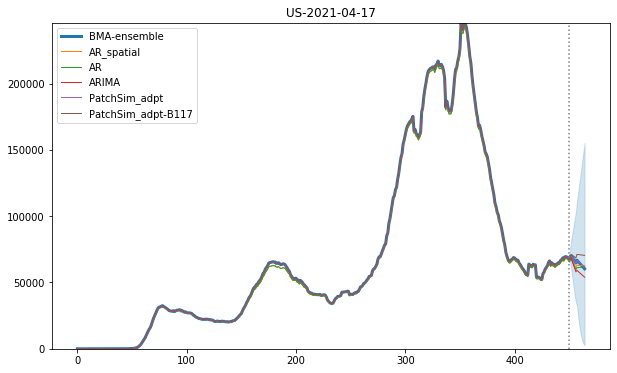

In [24]:
holieff=0
for hdt in [pdf.horizon.unique().max()]:#['2020-10-25', '2020-10-18', '2020-10-11', '2020-10-04']:
    obsdt=(datetime.strptime(hdt,'%Y-%m-%d')+timedelta(days=6)).strftime('%Y-%m-%d')
    st='US'
    fig,ax=plt.subplots(1,1,figsize=(10,6))
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    clr=0
    st_cn_list=fipsdict['FIPS'].values
    rndf=ddf[ddf.index.isin(st_cn_list)].sum().rolling(7).mean().fillna(0)
    for mtd in ['BMA-ensemble', 'AR_spatial', 'AR','ARIMA', 'ENKF',  'PatchSim_adpt','PatchSim_adpt-B117']:#'AR_spatial_mob','ARIMA','lstm',
        try:
            print(mtd)
            mask=(pdf.method==mtd)&(pdf.horizon==hdt)
            ddf_med=conv_patch_2weeks(pdf[mask],'fct_mean')
            ddf_lb=conv_patch_2weeks(pdf[mask],'fct_lb')
            ddf_ub=conv_patch_2weeks(pdf[mask],'fct_ub')
            if holieff==1 and mtd=='BMA_ensemble':
                ddf_med,ddf_lb,ddf_ub=holiday_effect(ddf_med, ddf_lb, ddf_ub,lastcols)

            col0=ddf_med.columns[0]
            ddf_med=ddf_med.drop(col0,axis=1)
            ddf_lb=ddf_lb.drop(col0,axis=1)
            ddf_ub=ddf_ub.drop(col0,axis=1)

            ll=[]
            st0=ddf_med.columns[0]
            for i in ddf_med.columns:
                ddf_med=ddf_med.rename(columns={i:(i-st0).days})

            ll=[]
            st0=ddf_lb.columns[0]
            for i in ddf_lb.columns:
                ddf_lb=ddf_lb.rename(columns={i:(i-st0).days})
            ddf_lb[ddf_lb<=0]=0
            ll=[]
            st0=ddf_ub.columns[0]
            for i in ddf_ub.columns:
                ddf_ub=ddf_ub.rename(columns={i:(i-st0).days})
            ddf_ub[ddf_ub<=0]=0

            if mtd=='BMA-ensemble':
                alp=1
                lw=3
            else:
                alp=0.4
                lw=1

            cols=list(ddf_med.columns)
            ax.plot(ddf_med[ddf_med.index.isin(st_cn_list)].sum().values,color=cycle[clr],label=mtd, linewidth=lw)
            if mtd=='BMA-ensemble':
                ax.fill_between(cols,ddf_lb[ddf_lb.index.isin(st_cn_list)].sum().values,ddf_ub[ddf_ub.index.isin(st_cn_list)].sum().values,alpha=0.2,color=cycle[clr])
                ymax=ddf_ub[ddf_ub.index.isin(st_cn_list)].sum().max()
            ax.set_title('{}-{}'.format(st,obsdt))
            clr+=1
        except:
            print('{} some issue'.format(mtd))
#     ax.plot(rndf.values,label='GT',color='black',linewidth=1)
    ax.axvline(x=dtdict[obsdt],color='grey',linestyle=':')
    ax.set_ylim(0,ymax)
    ax.legend()
    plt.savefig('plots/cdc_forecast_ensemble/US_2_week_wtd_BMA_{}_{}.pdf'.format(st,obsdt),bbox_inches='tight')


    #     fig.autofmt_xdate()

In [26]:
holieff=0
obsdt=(datetime.strptime(pdt,'%Y-%m-%d')+timedelta(days=6)).strftime('%Y-%m-%d')
for mtd in ['BMA-ensemble']:#,'AR_spatial_mob', 'AR_spatial', 'AR', 'ARIMA','ENKF', 'lstm', 'PatchSim_adpt']:
    mask=(pdf.method==mtd)&(pdf.horizon==hdt)
    ddf_med=conv_patch(pdf[mask],'fct_mean')
    ddf_lb=conv_patch(pdf[mask],'fct_lb')
    ddf_ub=conv_patch(pdf[mask],'fct_ub')
    if holieff==1 and mtd=='BMA_ensemble':
        ddf_med,ddf_lb,ddf_ub=holiday_effect(ddf_med, ddf_lb, ddf_ub,lastcols)
    col0=ddf_med.columns[0]
    ddf_med=ddf_med.drop(col0,axis=1)
    ddf_lb=ddf_lb.drop(col0,axis=1)
    ddf_ub=ddf_ub.drop(col0,axis=1)
    
    
    
    ll=[]
    st0=ddf_med.columns[0]
    for i in ddf_med.columns:
        ddf_med=ddf_med.rename(columns={i:(i-st0).days})

    ll=[]
    st0=ddf_lb.columns[0]
    for i in ddf_lb.columns:
        ddf_lb=ddf_lb.rename(columns={i:(i-st0).days})
    ddf_lb[ddf_lb<=0]=0
    ll=[]
    st0=ddf_ub.columns[0]
    for i in ddf_ub.columns:
        ddf_ub=ddf_ub.rename(columns={i:(i-st0).days})
    ddf_ub[ddf_ub<=0]=0

In [27]:
obsdt

'2021-04-17'

In [28]:
# # reddf.reset_index()

# ddf_med=ddf_med.reset_index().rename(columns={'index':'FIPS'}).merge(stdf).merge(reddf.reset_index())
# ddf_lb=ddf_lb.reset_index().rename(columns={'index':'FIPS'}).merge(stdf).merge(reddf.reset_index())
# ddf_ub=ddf_ub.reset_index().rename(columns={'index':'FIPS'}).merge(stdf).merge(reddf.reset_index())

# ddf_med.loc[:,lastcols]=ddf_med[lastcols]-ddf_med[lastcols].multiply(ddf_med.loc[:,'red_fac'],axis='index')
# ddf_lb.loc[:,lastcols]=ddf_lb[lastcols]-ddf_lb[lastcols].multiply(ddf_lb.loc[:,'red_fac'],axis='index')
# ddf_ub.loc[:,lastcols]=ddf_ub[lastcols]-ddf_ub[lastcols].multiply(ddf_ub.loc[:,'red_fac'],axis='index')

# ddf_med=ddf_med.set_index('FIPS').drop(['State_code','red_fac'],axis=1)
# ddf_lb=ddf_lb.set_index('FIPS').drop(['State_code','red_fac'],axis=1)
# ddf_ub=ddf_ub.set_index('FIPS').drop(['State_code','red_fac'],axis=1)

In [29]:
ddf_med.to_csv('/project/biocomplexity/aniadiga/covid-19_forecast/ensemble/DTRA_VDH//{}-UVA-Ensemble_med.csv'.format(obsdt))
ddf_lb.to_csv('/project/biocomplexity/aniadiga/covid-19_forecast/ensemble/DTRA_VDH//{}-UVA-Ensemble_lb.csv'.format(obsdt))
ddf_ub.to_csv('/project/biocomplexity/aniadiga/covid-19_forecast/ensemble/DTRA_VDH/{}-UVA-Ensemble_ub.csv'.format(obsdt))

In [44]:
def holiday_effect(ddf_med, ddf_lb, ddf_ub,lastcols):
    ddf_med=ddf_med.reset_index().rename(columns={'index':'FIPS'}).merge(stdf).merge(reddf.reset_index())
    ddf_lb=ddf_lb.reset_index().rename(columns={'index':'FIPS'}).merge(stdf).merge(reddf.reset_index())
    ddf_ub=ddf_ub.reset_index().rename(columns={'index':'FIPS'}).merge(stdf).merge(reddf.reset_index())

    ddf_med.loc[:,lastcols]=ddf_med[lastcols]-ddf_med[lastcols].multiply(ddf_med.loc[:,'red_fac'],axis='index')
    ddf_lb.loc[:,lastcols]=ddf_lb[lastcols]-ddf_lb[lastcols].multiply(ddf_lb.loc[:,'red_fac'],axis='index')
    ddf_ub.loc[:,lastcols]=ddf_ub[lastcols]-ddf_ub[lastcols].multiply(ddf_ub.loc[:,'red_fac'],axis='index')

    ddf_med=ddf_med.set_index('FIPS').drop(['State_code','red_fac'],axis=1)
    ddf_lb=ddf_lb.set_index('FIPS').drop(['State_code','red_fac'],axis=1)
    ddf_ub=ddf_ub.set_index('FIPS').drop(['State_code','red_fac'],axis=1)
    return ddf_med, ddf_lb, ddf_ub

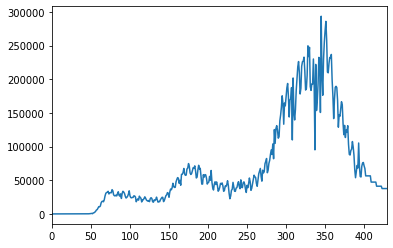

In [28]:
ddf_med.loc[:].sum().plot()

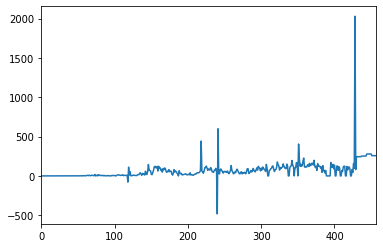

In [32]:
ddf_med.loc['48041'].plot()

In [94]:
stdf=fipsdf[['FIPS','State_code']]
usstdf=new_df
usstdf=usstdf.reset_index().merge(stdf)
usstdf=usstdf.groupby('State_code').sum()
dt=['2020-11-15','2020-11-22','2020-11-29']
tpdf=usstdf.loc[:,[dt[0],dt[1],dt[2]]]
reddf=pd.DataFrame(index=usstdf.index,columns=['red_fac'])
reddf.loc[:,'red_fac']=(((tpdf.loc[:,dt[2]]+tpdf.loc[:,dt[0]])/2)-(tpdf.loc[:,dt[1]]))/tpdf.loc[:,dt[1]]
# reddf[reddf['red_fac']<0]=0

In [58]:
tpdf.to_csv('output/TG_pre-post-weeks.csv',index=None)

In [94]:
reddf.to_csv('output/TG_reduction_factor_states.csv',index=None)

In [93]:
reddf=reddf.reset_index().merge(stdf[['stFIPS','State_code']].drop_duplicates(),how='left')

In [169]:
ax.get_xticklabels()[]

Text(0.0, 0, '2021-01-01')

In [32]:
ddf_med.index.unique()

Index(['01001', '01003', '01005', '01007', '01009', '01011', '01013', '01015',
       '01017', '01019',
       ...
       '56027', '56029', '56031', '56033', '56035', '56037', '56039', '56041',
       '56043', '56045'],
      dtype='object', length=3142)

In [211]:
ll=[]
for i in range(3):
    for j in range(2):
        ll.append((i,j))

(1, 0)

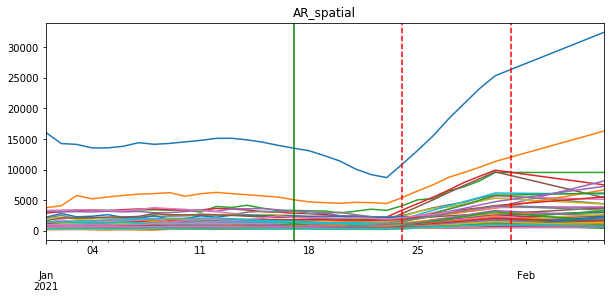

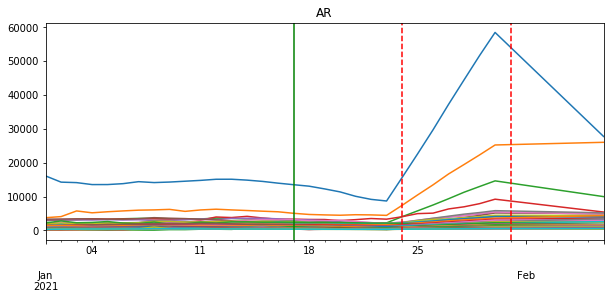

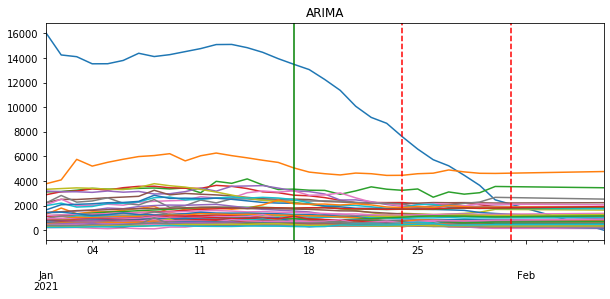

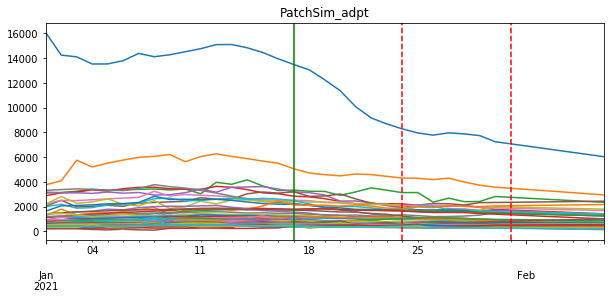

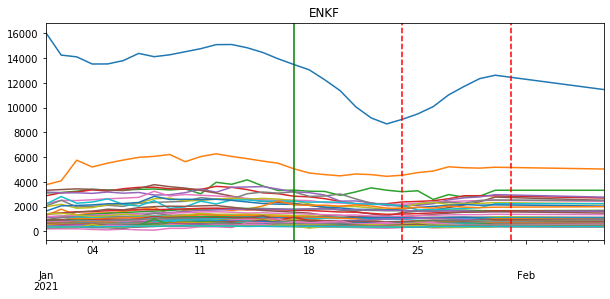

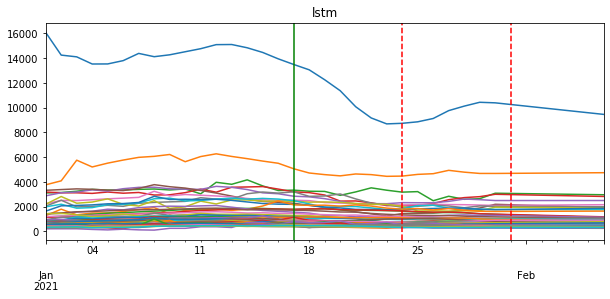

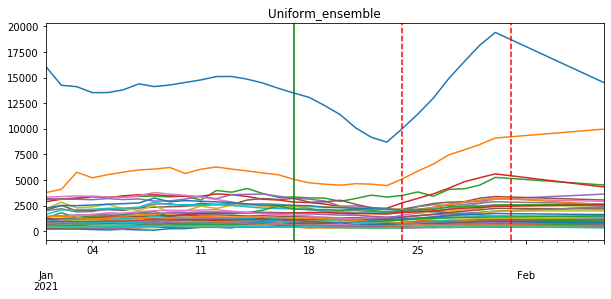

In [222]:
hdt='2021-01-17'
for mtd in ['AR_spatial', 'AR', 'ARIMA', 'PatchSim_adpt', 'ENKF', 'lstm','Uniform_ensemble']:
    fig,ax=plt.subplots(1,1,figsize=(10,4))
    mask=(pdf.method==mtd)&(pdf.horizon==hdt)
    ddf_med=conv_patch_2weeks(pdf[mask],'fct_mean')
#     for col in ddf_med.columns:
#         ddf_med=ddf_med.rename(columns={col:col.strftime('%Y-%d-%m')})
    fctdt=sorted(pdf[mask].fct_date.unique())[:2]
    # st_cn_list=fipsdict[fipsdict.location_code=='VA']['FIPS'].values
    # (ddf_med.loc[:,'2021-01-01':].sum(axis=1)).sort_values(ascending=False)[:100]
    temp=(ddf_med.loc[:,'2021-01-01':].sum(axis=1)).sort_values(ascending=False)
    cntmp=temp.index[:100]
    temp=(ddf_med.loc[:,'2021-01-01':].sum(axis=1)).sort_values(ascending=False)
    cntmp=temp.index[:100]
    ddf_med.loc[cntmp,'2021-01-01':].T.plot(ax=ax,legend=None)
    ax.axvline(x=hdt,color='green')
    ax.axvline(x=fctdt[0],color='red',linestyle='--')
    ax.axvline(x=fctdt[1],color='red',linestyle='--')
    ax.set_title(mtd)
    mdf=pd.DataFrame(columns=ddf_med.columns,index=cntmp)
#     for cn in cntmp:
#         mdf.loc[cn,fctdt[0]]=owdf[(owdf.method==mtd)&(owdf.horizon==hdt)&(owdf.fct_date==fctdt[0])&(owdf.cnty==cn)]['wts_bias'].values[0]
#         mdf.loc[cn,fctdt[1]]=owdf[(owdf.method==mtd)&(owdf.horizon==hdt)&(owdf.fct_date==fctdt[1])&(owdf.cnty==cn)]['wts_bias'].values[0]
        
#         x0=owdf[(owdf.method==mtd)&(owdf.horizon==hdt)&(owdf.fct_date==fctdt[0])&(owdf.cnty==cn)]['wts_bias'].values[0]
#         x1=owdf[(owdf.method==mtd)&(owdf.horizon==hdt)&(owdf.fct_date==fctdt[1])&(owdf.cnty==cn)]['wts_bias'].values[0]
#         plt.plot(fctdt[0],ddf_med.loc[cn,fctdt[0]],marker='o',markersize=20*x0,ax=ax)
#         plt.plot(fctdt[1],ddf_med.loc[cn,fctdt[0]],marker='o',markersize=20*x1,ax=ax)
    # ddf_med.loc[cntmp].sum().T.plot(ax=ax,color='black')

In [185]:
owdf[(owdf.horizon==hdt)&(owdf.step_ahead=='1-step_ahead')&(owdf.cnty.isin(cntmp[:10]))].pivot(index='cnty',columns='method',values='wts_bias')

method,AR,ARIMA,AR_spatial,ENKF,PatchSim_adpt,lstm
cnty,,,,,,
04013,6.856272e-08,3.224891e-06,2.065736e-03,1.416005e-06,4.243857e-02,3.721308e-01
06037,1.919073e-08,4.289236e-10,9.564081e-01,4.564598e-12,1.348645e-06,6.555688e-09
06059,4.422536e-01,5.463790e-02,1.652746e-08,2.869886e-01,3.685337e-11,2.638784e-07
06065,6.648184e-02,7.196820e-06,8.021576e-01,1.014229e-07,4.084704e-11,1.279624e-10
06071,2.386764e-07,9.999645e-01,4.083028e-10,4.707651e-06,7.935119e-13,2.934581e-12
06073,1.741055e-04,2.714091e-08,2.198858e-04,1.611052e-10,2.234254e-09,9.979037e-01
17031,5.104473e-06,9.418792e-01,1.233634e-02,1.333826e-10,2.282455e-09,2.623454e-09
48113,4.746436e-05,9.991780e-01,9.642100e-09,2.817264e-04,8.128899e-12,6.528571e-12
48201,1.037956e-05,5.821262e-09,3.365205e-10,3.593062e-10,9.991570e-01,2.339153e-05


In [206]:
tmdf=owdf[(owdf.horizon==hdt)&(owdf.step_ahead=='1-step_ahead')&(owdf.cnty.isin(cntmp[:10]))].pivot(index='cnty',columns='method',values='wts_bias')
tmdf['tot']=tmdf.sum(axis=1)
for col in ['AR', 'ARIMA', 'AR_spatial', 'ENKF', 'PatchSim_adpt', 'lstm']:
    tmdf[col]=tmdf[col]/tmdf['tot']
tmdf=tmdf.drop('tot',axis=1)

In [207]:
tmdf

method,AR,ARIMA,AR_spatial,ENKF,PatchSim_adpt,lstm
cnty,,,,,,
04013,1.645611e-07,7.740237e-06,4.958086e-03,3.398631e-06,1.018591e-01,8.931715e-01
06037,2.006539e-08,4.484728e-10,9.999986e-01,4.772640e-12,1.410113e-06,6.854478e-09
06059,5.641850e-01,6.970183e-02,2.108417e-08,3.661128e-01,4.701403e-11,3.366310e-07
06065,7.653495e-02,8.285094e-06,9.234566e-01,1.167597e-07,4.702377e-11,1.473123e-10
06071,2.386837e-07,9.999951e-01,4.083152e-10,4.707795e-06,7.935361e-13,2.934671e-12
06073,1.744024e-04,2.718719e-08,2.202608e-04,1.613799e-10,2.238064e-09,9.996053e-01
17031,5.349363e-06,9.870665e-01,1.292818e-02,1.397817e-10,2.391957e-09,2.749316e-09
48113,4.748777e-05,9.996706e-01,9.646854e-09,2.818653e-04,8.132907e-12,6.531790e-12
48201,1.038797e-05,5.825976e-09,3.367931e-10,3.595972e-10,9.999662e-01,2.341047e-05


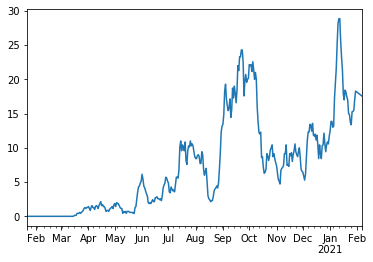

In [224]:
ddf_med.loc['51540'].plot()

cnty
04013    1.971514
06037    1.037840
06059    1.791364
06065    1.873771
06071    1.982942
06073    1.820501
17031    1.998959
48113    1.598097
48201    1.878825
48439    1.086150
dtype: float64

In [181]:
# fctdt[0]=datetime.strptime(fctdt[0],'%Y-%m-%d')
# fctdt[1]=datetime.strptime(fctdt[1],'%Y-%m-%d')

In [144]:
fctdt[0],ddf_med.loc[cn,fctdt[0]]

('2021-01-24', 10867.753601442275)

In [166]:
fctdt[0]=fctdt[0].strftime('%Y-%m-%d')
fctdt[1]=fctdt[1].strftime('%Y-%m-%d')

AttributeError: 'str' object has no attribute 'strftime'

In [115]:
owdf=pd.read_csv('output/all_weeks_wts_with_bias_no_mob.csv')
owdf['cnty']=pd.to_numeric(owdf.cnty)
owdf['cnty']=owdf.cnty.apply(lambda x: '{:05}'.format(int(x)))

In [121]:
owdf['hrzn']=owdf['step_ahead'].str[:1].astype(int)

In [165]:
owdf['fct_date']=(pd.to_datetime(owdf['horizon'],format='%Y-%m-%d')+pd.to_timedelta(owdf['hrzn'],unit='W')).dt.strftime('%Y-%m-%d')

51041 Chesterfield_Virginia
51059 Fairfax_Virginia
51087 Henrico_Virginia
51107 Loudoun_Virginia
51153 Prince William_Virginia
51550 Chesapeake City_Virginia
51650 Hampton City_Virginia
51700 Newport News City_Virginia
51710 Norfolk City_Virginia
51760 Richmond City_Virginia
51810 Virginia Beach City_Virginia


In [155]:
# new_df.sum(axis=1).sort_values(ascending=False)


'2020-22-01'

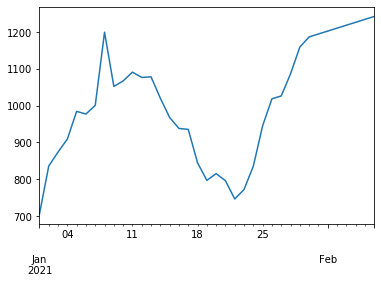

In [150]:
fig,ax=plt.subplots()
ddf_med.loc[cn,'2021-01-01':].T.plot(ax=ax)
# ax.plot_date(fctdt[0],ddf_med.loc[cn,fctdt[0]])

In [73]:
ddf_med.sum(axis=1).sort_values(ascending=False)[:100]

06037    1.372329e+06
04013    5.887303e+05
17031    4.776447e+05
06065    3.632620e+05
48201    3.551867e+05
             ...     
08031    5.789400e+04
34031    5.787302e+04
25005    5.741168e+04
42091    5.647484e+04
06107    5.456020e+04
Length: 100, dtype: float64

In [70]:
owdf

,horizon,step_ahead,cnty,method,wts_bias,std
0,2020-11-15,1-step_ahead,21057,AR_spatial,2.090603e-01,0.464148
1,2020-11-15,1-step_ahead,21057,AR,1.983904e-01,0.171563
2,2020-11-15,1-step_ahead,21057,ARIMA,6.134088e-05,0.121189
3,2020-11-15,1-step_ahead,21057,PatchSim_adpt,9.531939e-02,0.126624
4,2020-11-15,1-step_ahead,21057,lstm,1.024515e-01,0.089110
5,2020-11-15,1-step_ahead,21057,ENKF,3.978807e-01,0.980493
6,2020-11-15,1-step_ahead,21035,AR_spatial,2.374643e-01,1.284963
7,2020-11-15,1-step_ahead,21035,AR,2.271497e-01,0.286943
8,2020-11-15,1-step_ahead,21035,ARIMA,6.436705e-12,0.157758
9,2020-11-15,1-step_ahead,21035,PatchSim_adpt,2.670833e-01,2.429507
